In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt    
from sklearn.model_selection import train_test_split

In [2]:
def create_ts_dataset(
                        data_path='data/Solar Generation.csv',
                        hh_dict = {
                                'Partly Sunny': 0,
                                'Sunny': 1, 'Partly Cloudy':2,
                                'Cloudy': 3, 'Rainy': 4
                                },
                        sel_window = 30,
                        pred_window = 1
                        ):
        df = pd.read_csv(data_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Weather Condition'] = df['Weather Condition'].map(hh_dict)
        del df['Timestamp']

        X, Y1, Y2, Y3 = [], [], [], []
        for i in range(len(df) - sel_window - pred_window):
                data = df.iloc[i:i+sel_window]
                y1 = df.iloc[i+sel_window:i+sel_window+pred_window]['Solar Generation (kWh)'] * 1000
                y2 = df.iloc[i+sel_window:i+sel_window+pred_window]['Weather Condition']
                y3 = df.iloc[i+sel_window:i+sel_window+pred_window]['Temperature (°C)']
                X.append(data.values)
                Y1.append(y1.values)
                Y2.append(y2.values)
                Y3.append(y3.values)

        X = np.array(X).squeeze()
        Y1 = np.array(Y1).squeeze()
        Y2 = np.array(Y2).squeeze()
        Y3 = np.array(Y3).squeeze()

        return X, Y1, Y2, Y3

In [3]:
X, Y1, Y2, Y3 = create_ts_dataset()
print(f"X shape: {X.shape}\nY1 shape: {Y1.shape}\nY2 shape: {Y2.shape}\nY3 shape: {Y3.shape}")

X shape: (2526, 30, 3)
Y1 shape: (2526,)
Y2 shape: (2526,)
Y3 shape: (2526,)


In [4]:
input_layer = tf.keras.Input(shape=(X.shape[1], X.shape[2]))
x = tf.keras.layers.GRU(256, return_sequences=True)(input_layer)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(32)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

o1 = tf.keras.layers.Dense(1, name ='o1')(x)
o2 = tf.keras.layers.Dense(1, name ='o2')(x)
o3 = tf.keras.layers.Dense(1, name ='o3')(x)

gru_model = tf.keras.Model(
                            inputs=input_layer, 
                            outputs=[o1, o2, o3]
                            )

gru_model.compile(
                    optimizer='adam', 
                    metrics=['mae'],
                    loss='mse'
                    )
gru_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 3)]      0           []                               
                                                                                                  
 gru (GRU)                      (None, 30, 256)      200448      ['input_1[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 30, 128)      148224      ['gru[0][0]']                    
                                                                                                  
 gru_2 (GRU)                    (None, 32)           15552       ['gru_1[0][0]']                  
                                                                                              

In [5]:
history = gru_model.fit(
                         X, [Y1, Y2, Y3],
                         epochs=100, batch_size=64 , 
                         validation_split=0.2,
                         callbacks=[
                                   tf.keras.callbacks.EarlyStopping(
                                                                 patience=25, 
                                                                 restore_best_weights=True
                                                                 )
                                   ]
                        )

Epoch 1/100
32/32 [==============================] - 7s 49ms/step - loss: 209411664.0000 - o1_loss: 209410976.0000 - o2_loss: 6.1542 - o3_loss: 716.9008 - o1_mae: 13785.4150 - o2_mae: 2.0709 - o3_mae: 26.7633 - val_loss: 212307968.0000 - val_o1_loss: 212307216.0000 - val_o2_loss: 5.7278 - val_o3_loss: 729.0193 - val_o1_mae: 13890.5117 - val_o2_mae: 1.9869 - val_o3_mae: 26.9881
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 209386480.0000 - o1_loss: 209385744.0000 - o2_loss: 6.7437 - o3_loss: 718.3347 - o1_mae: 13784.4961 - o2_mae: 2.2062 - o3_mae: 26.7900 - val_loss: 212257136.0000 - val_o1_loss: 212256432.0000 - val_o2_loss: 6.9037 - val_o3_loss: 712.2945 - val_o1_mae: 13888.6836 - val_o2_mae: 2.2372 - val_o3_mae: 26.6764
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 209318400.0000 - o1_loss: 209317696.0000 - o2_loss: 6.0831 - o3_loss: 703.6758 - o1_mae: 13782.0234 - o2_mae: 2.0719 - o3_mae: 26.5148 - val_loss: 212164912.0000 - va

In [6]:
gru_model.save('artifacts/solar_generation.h5')

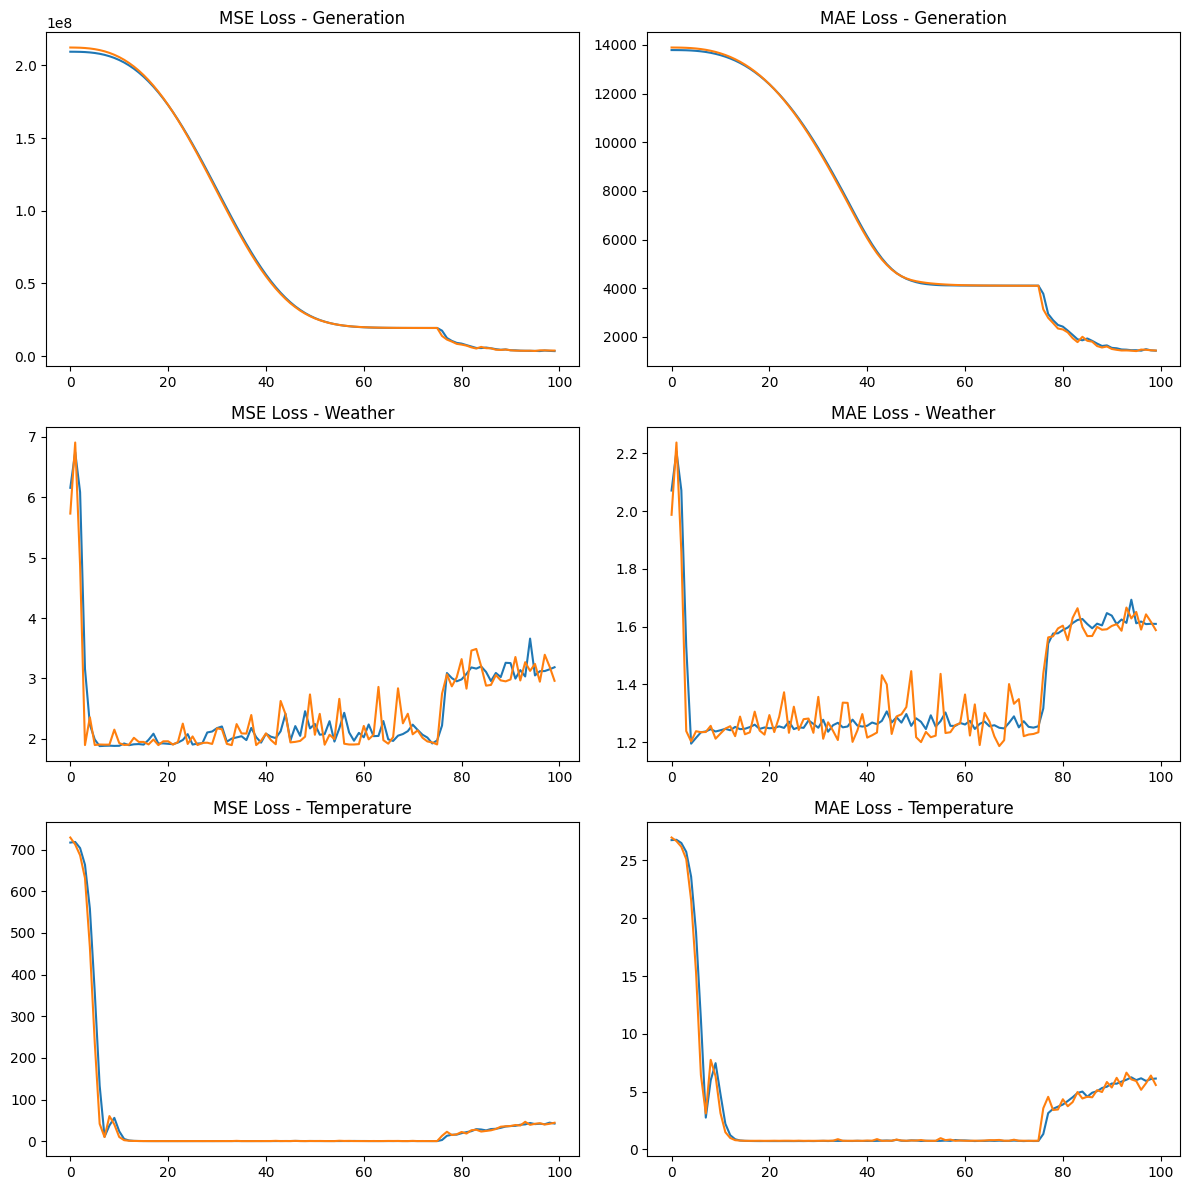

In [7]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['o1_loss'], label='Training Loss')
plt.plot(history.history['val_o1_loss'], label='Validation Loss')
plt.title('MSE Loss - Generation')

plt.subplot(3, 2, 2)
plt.plot(history.history['o1_mae'], label='Training MAE')
plt.plot(history.history['val_o1_mae'], label='Validation MAE')
plt.title('MAE Loss - Generation')

plt.subplot(3, 2, 3)
plt.plot(history.history['o2_loss'], label='Training Loss')
plt.plot(history.history['val_o2_loss'], label='Validation Loss')
plt.title('MSE Loss - Weather')

plt.subplot(3, 2, 4)
plt.plot(history.history['o2_mae'], label='Training MAE')
plt.plot(history.history['val_o2_mae'], label='Validation MAE')
plt.title('MAE Loss - Weather')

plt.subplot(3, 2, 5)
plt.plot(history.history['o3_loss'], label='Training Loss')
plt.plot(history.history['val_o3_loss'], label='Validation Loss')
plt.title('MSE Loss - Temperature')

plt.subplot(3, 2, 6)
plt.plot(history.history['o3_mae'], label='Training MAE')
plt.plot(history.history['val_o3_mae'], label='Validation MAE')
plt.title('MAE Loss - Temperature')

plt.tight_layout()
plt.show()

In [14]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf

In [15]:
model_solar_gen = tf.keras.models.load_model('artifacts/solar_generation.h5')
model_solar_gen.compile(
                        optimizer='adam', 
                        metrics=['mae'],
                        loss='mse'
                        )

In [24]:
def generate_temperature(weather_condition):
    temperature_ranges = {
        'Partly Sunny': (15, 25),
        'Sunny': (20, 35),
        'Partly Cloudy': (10, 20),
        'Cloudy': (5, 15),
        'Rainy': (5, 18)
    }
    
    if weather_condition in temperature_ranges:
        temp_min, temp_max = temperature_ranges[weather_condition]
        return round(random.uniform(temp_min, temp_max), 1)
    else:
        return "Unknown weather condition"
    
def inference_solar_(
                data_path='data/Solar Generation.csv',
                hh_dict = {
                        'Partly Sunny': 0,
                        'Sunny': 1, 'Partly Cloudy':2,
                        'Cloudy': 3, 'Rainy': 4
                        },
                sel_window = 30,
                pred_window = 1
                ):
        df = pd.read_csv(data_path)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Weather Condition'] = df['Weather Condition'].map(hh_dict)
        del df['Timestamp']
        
        data = df.iloc[-sel_window:]
        data_ = df.iloc[-pred_window:]['Solar Generation (kWh)'] * 1000
        prev_generation = float(data_.iloc[0])

        data = np.expand_dims(data.values, axis=0)
        prediction = model_solar_gen.predict(data)
        
        generation = float(prediction[0][0])
        weather = float(prediction[1][0])
        temperature = float(prediction[2][0])

        percentage_change = ((generation - prev_generation) / prev_generation) * 100
        weather = weather + 1 if (weather - int(weather)) >= 0.5 else int(weather)
        weather = list(hh_dict.keys())[int(weather)]
        temperature = round(float(temperature), 1)
        generation = round(float(generation), 1)
        # temperature = generate_temperature(weather)
        return {
                'generation': f"{generation} kWh",
                'weather': weather,
                'temperature': f"{temperature}°C",
                'percentage_change': f"{round(percentage_change, 2)}%"
                }

In [25]:
inference_solar_()

1/1 [==============================] - 0s 20ms/step


{'generation': '9583.9 kWh',
 'weather': 'Partly Cloudy',
 'temperature': '16.3°C',
 'percentage_change': '-4.16%'}